# <font style="color: rgb(0,0,0);">Joined Model</font> <font style="color: rgb(190,138,67);">Relevance Comparison</font>

In [1]:
# imports
import numpy as np
import xarray as xr
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tqdm.notebook import tqdm
from prettytable import PrettyTable

inferno = cm.get_cmap('inferno', 256)
newcolors = inferno(np.linspace(0, 1, 256))
revinferno = ListedColormap(np.flip(newcolors,axis=0))

In [2]:
from helper_functions import *

In [3]:
# A Result
ISRU_data = xr.open_dataarray("maps/ISRU_COST_GLOBAL.nc").data
info(ISRU_data)

float32 (13680, 27360) data range: 17054.625 - 157718.5


In [4]:
# B Results
spent_fuel_NRHO_1_5 = xr.open_dataarray("maps/spent_fuel_NRHO_1_5.nc").data
spent_fuel_NRHO_2_5  = xr.open_dataarray("maps/spent_fuel_NRHO_2_0.nc").data
info(spent_fuel_NRHO_1_5)
info(spent_fuel_NRHO_2_5)

float64 (9, 18) data range: 2.166410998493994 - 4.5961265323240035
float64 (9, 18) data range: 1.8218499158200014 - 3.4727174727400065


In [5]:
# match resolution to be able to combine data
dsize = (5000,2500)

In [6]:
# upscale dv_data
# sadly no cv2 method available to supersample bicubic without distorting maximum and minimum values (as in the matplotlib figure in paper)
# -> linear interpolation
spent_fuel_NRHO_1_5_resized = cv2.resize(spent_fuel_NRHO_1_5, dsize=dsize, interpolation=cv2.INTER_LINEAR)
spent_fuel_NRHO_2_5_resized = cv2.resize(spent_fuel_NRHO_2_5, dsize=dsize, interpolation=cv2.INTER_LINEAR)
info(spent_fuel_NRHO_1_5_resized)
info(spent_fuel_NRHO_2_5_resized)

float64 (2500, 5000) data range: 2.166410998493994 - 4.5961265323240035
float64 (2500, 5000) data range: 1.8218499158200014 - 3.4727174727400065


In [7]:
ISRU_data_resized = cv2.resize(ISRU_data, dsize=dsize, interpolation=cv2.INTER_NEAREST)
info(ISRU_data_resized) 

float32 (2500, 5000) data range: 17054.625 - 157718.5


In [ ]:
# visual inspection of downsampled vs original data
plot_map(ISRU_data_resized,1,'ISRU Cost [kg]',(-90,90),(-180,180),i_steps=[],silent=True,labelsize=20)

In [ ]:
plot_map(ISRU_data,1,'ISRU Cost [kg]',(-90,90),(-180,180),i_steps=[],silent=True,labelsize=20)

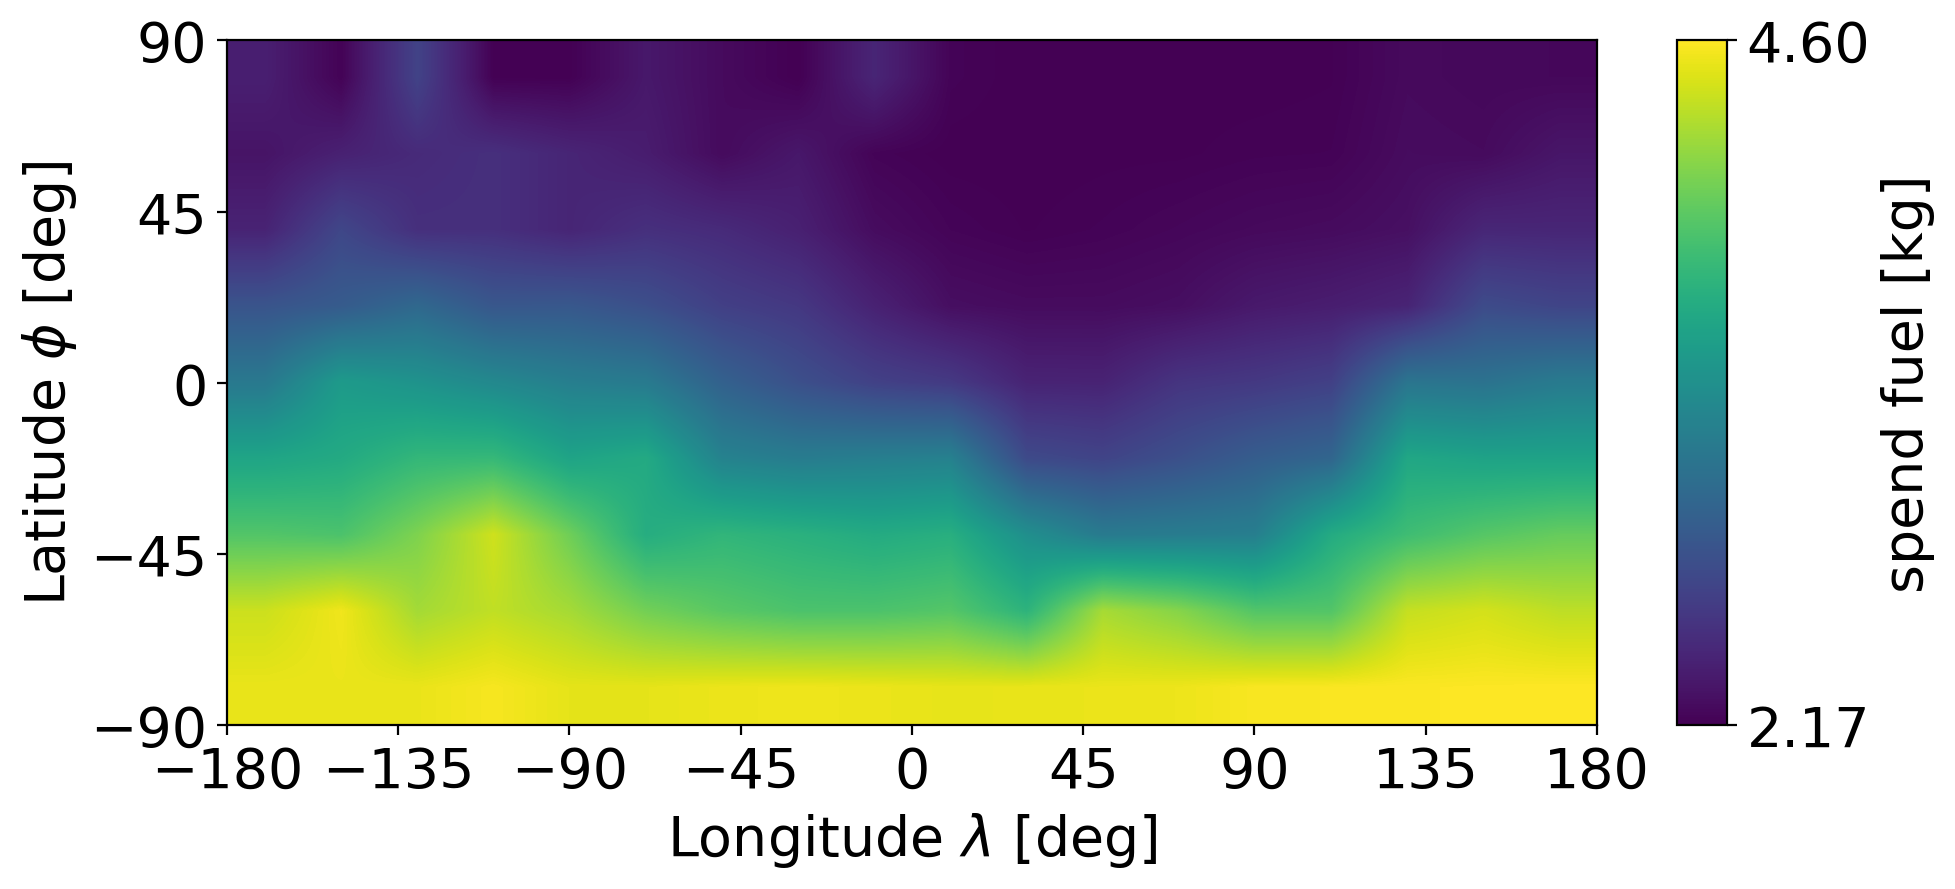

In [10]:
# visual inspection of upsampled vs original data
plot_map(spent_fuel_NRHO_1_5_resized,1,'spend fuel [kg]',(-90,90),(-180,180),i_steps=[],silent=True,labelsize=20)

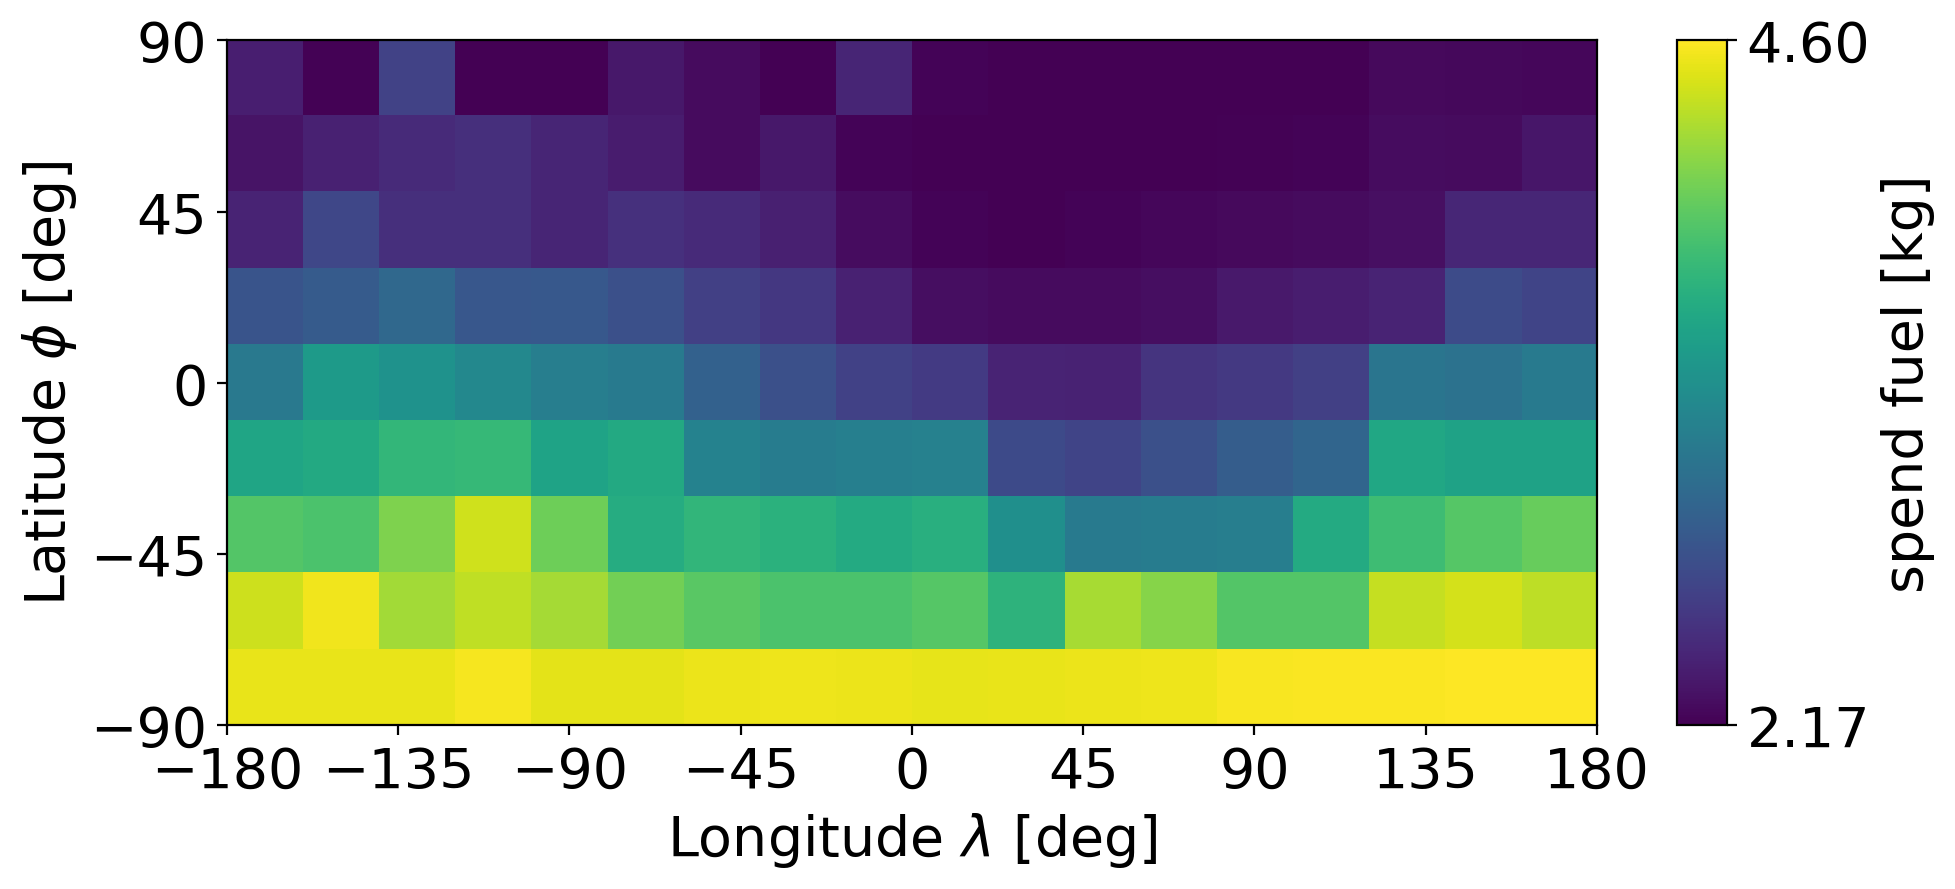

In [11]:
plot_map(spent_fuel_NRHO_1_5,1,'spend fuel [kg]',(-90,90),(-180,180),i_steps=[],silent=True,labelsize=20)

## Combined Model
assuming: cost = H2 fuel mass cost + extra mass for ISRU to match higher O2 demand

In [9]:
# assuming H2 fuel mass cost + extra mass for ISRU to match higher O2 demand

# cost_per_kg_payload = used_H2 + additional_ISRU_mass(used_O2_per_year)
# Total costs = ISRU_costs + t [years] * m_payload_per_year * cost_per_kg_payload

In [10]:
# ISRU mass per additional kg of Oxygen per year
ISRU_mass_per_kg = ISRU_data_resized / (23.9 * 1000)

In [11]:
m_payload_per_year = 8 * 1000 # [kg]  <- so that the cheapest resulting ISRU plant equals roughly the base configuration
m_ISRU_base_prod_per_year = 23.9 * 1000 # [kg]

of_ratio = 6
O2_factor = (of_ratio/(of_ratio+1))
H2_factor = (1/(of_ratio+1))

def total_costs_advanced_1_5(years, return_splits=False):
    spend_O2_per_year = m_payload_per_year * spent_fuel_NRHO_1_5_resized * O2_factor
    m_ISRU_additional = spend_O2_per_year + m_payload_per_year - m_ISRU_base_prod_per_year
    fix_costs_additionally = ISRU_mass_per_kg * m_ISRU_additional
    
    dynamic_costs_H2 = years * m_payload_per_year * spent_fuel_NRHO_1_5_resized * H2_factor
    
    res = ISRU_data_resized + fix_costs_additionally + dynamic_costs_H2
    
    if return_splits:
        return ISRU_data_resized + fix_costs_additionally, dynamic_costs_H2
    else:
        return res

def total_costs_advanced_2_5(years, return_splits=False):
    spend_O2_per_year = m_payload_per_year * spent_fuel_NRHO_2_5_resized * O2_factor
    m_ISRU_additional = spend_O2_per_year + m_payload_per_year - m_ISRU_base_prod_per_year
    fix_costs_additionally = ISRU_mass_per_kg * m_ISRU_additional
    
    dynamic_costs_H2 = years * m_payload_per_year * spent_fuel_NRHO_2_5_resized * H2_factor
    
    res = ISRU_data_resized + fix_costs_additionally + dynamic_costs_H2
    
    if return_splits:
        return ISRU_data_resized + fix_costs_additionally, dynamic_costs_H2
    else:
        return res

In [12]:
Total_cost_map_advanced_1_5 = total_costs_advanced_1_5(20)

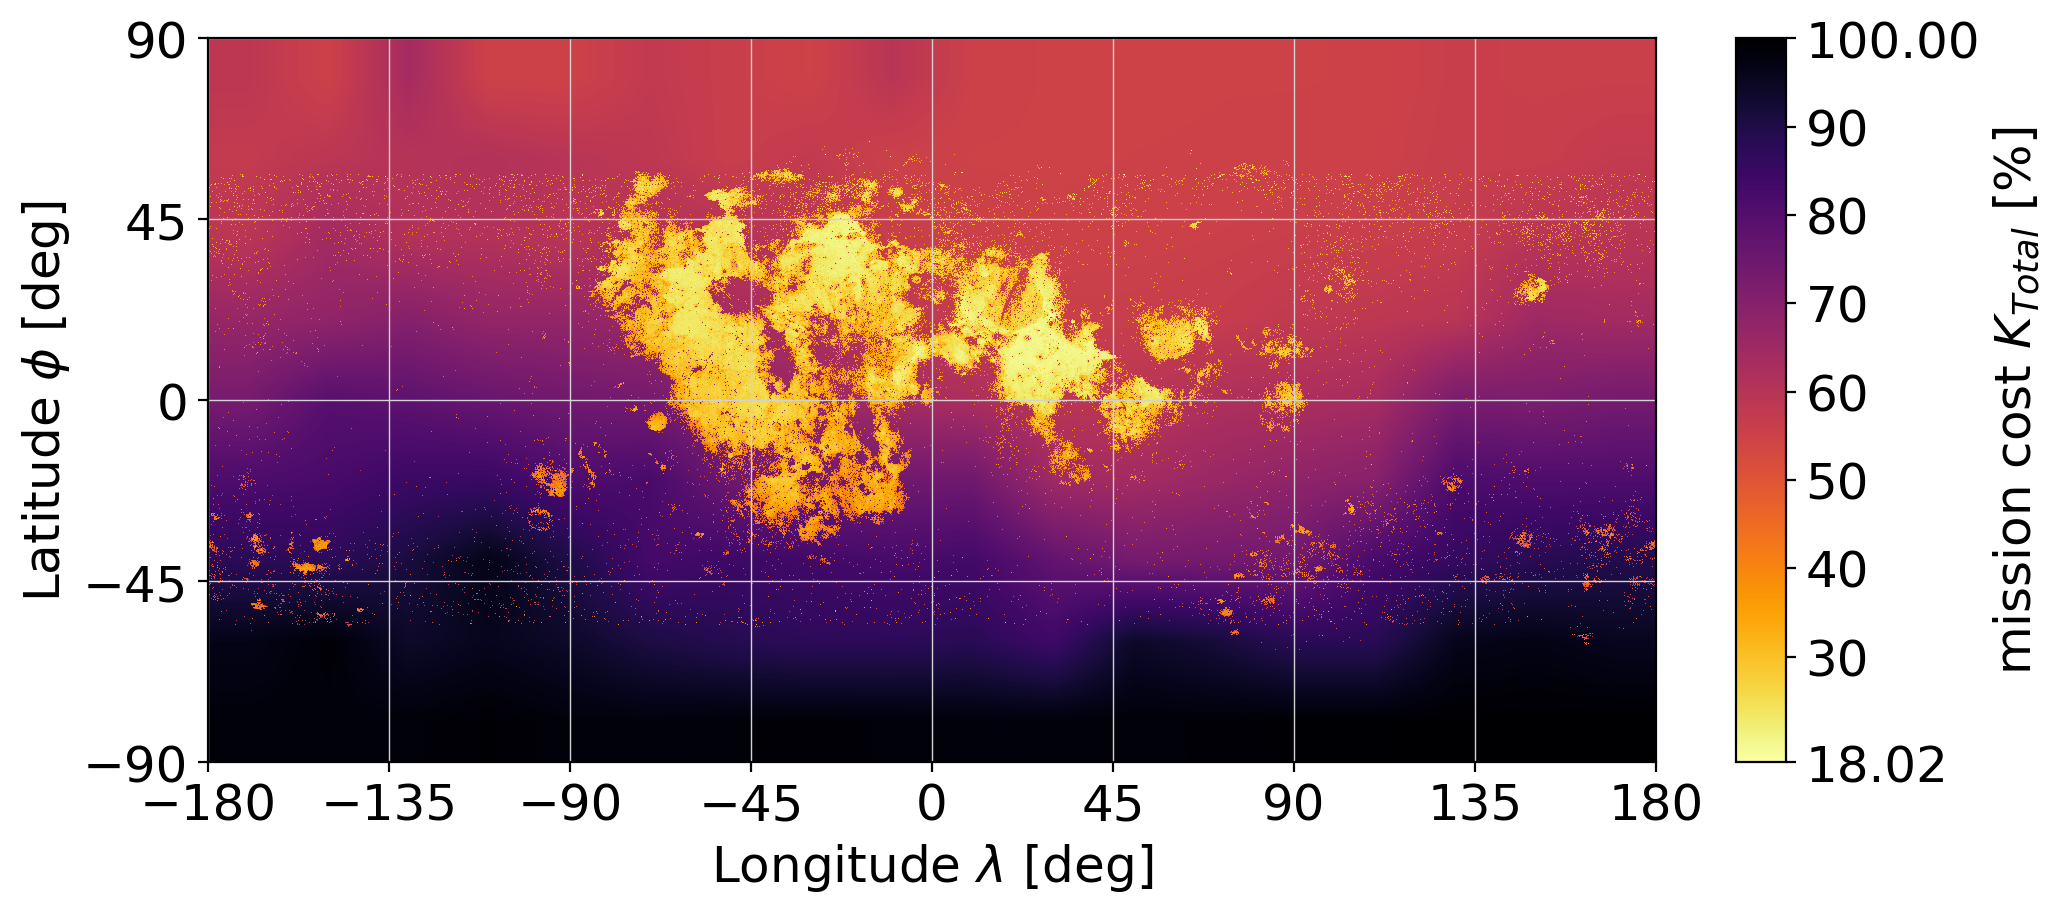

In [17]:
plot_map(Total_cost_map_advanced_1_5,np.max(Total_cost_map_advanced_1_5)/100,'mission cost $K_{Total}$ [%]',(-90,90),(-180,180),cmap=revinferno,i_steps=np.array([30,40,50,60,70,80,90])*(np.max(Total_cost_map_advanced_1_5)/100),silent=True,labelsize=18,save="Total_Cost_NRHO_1_5.pdf",gridcolor='lightgray')

In [15]:
Total_cost_map_advanced_2_5 = total_costs_advanced_2_5(20)

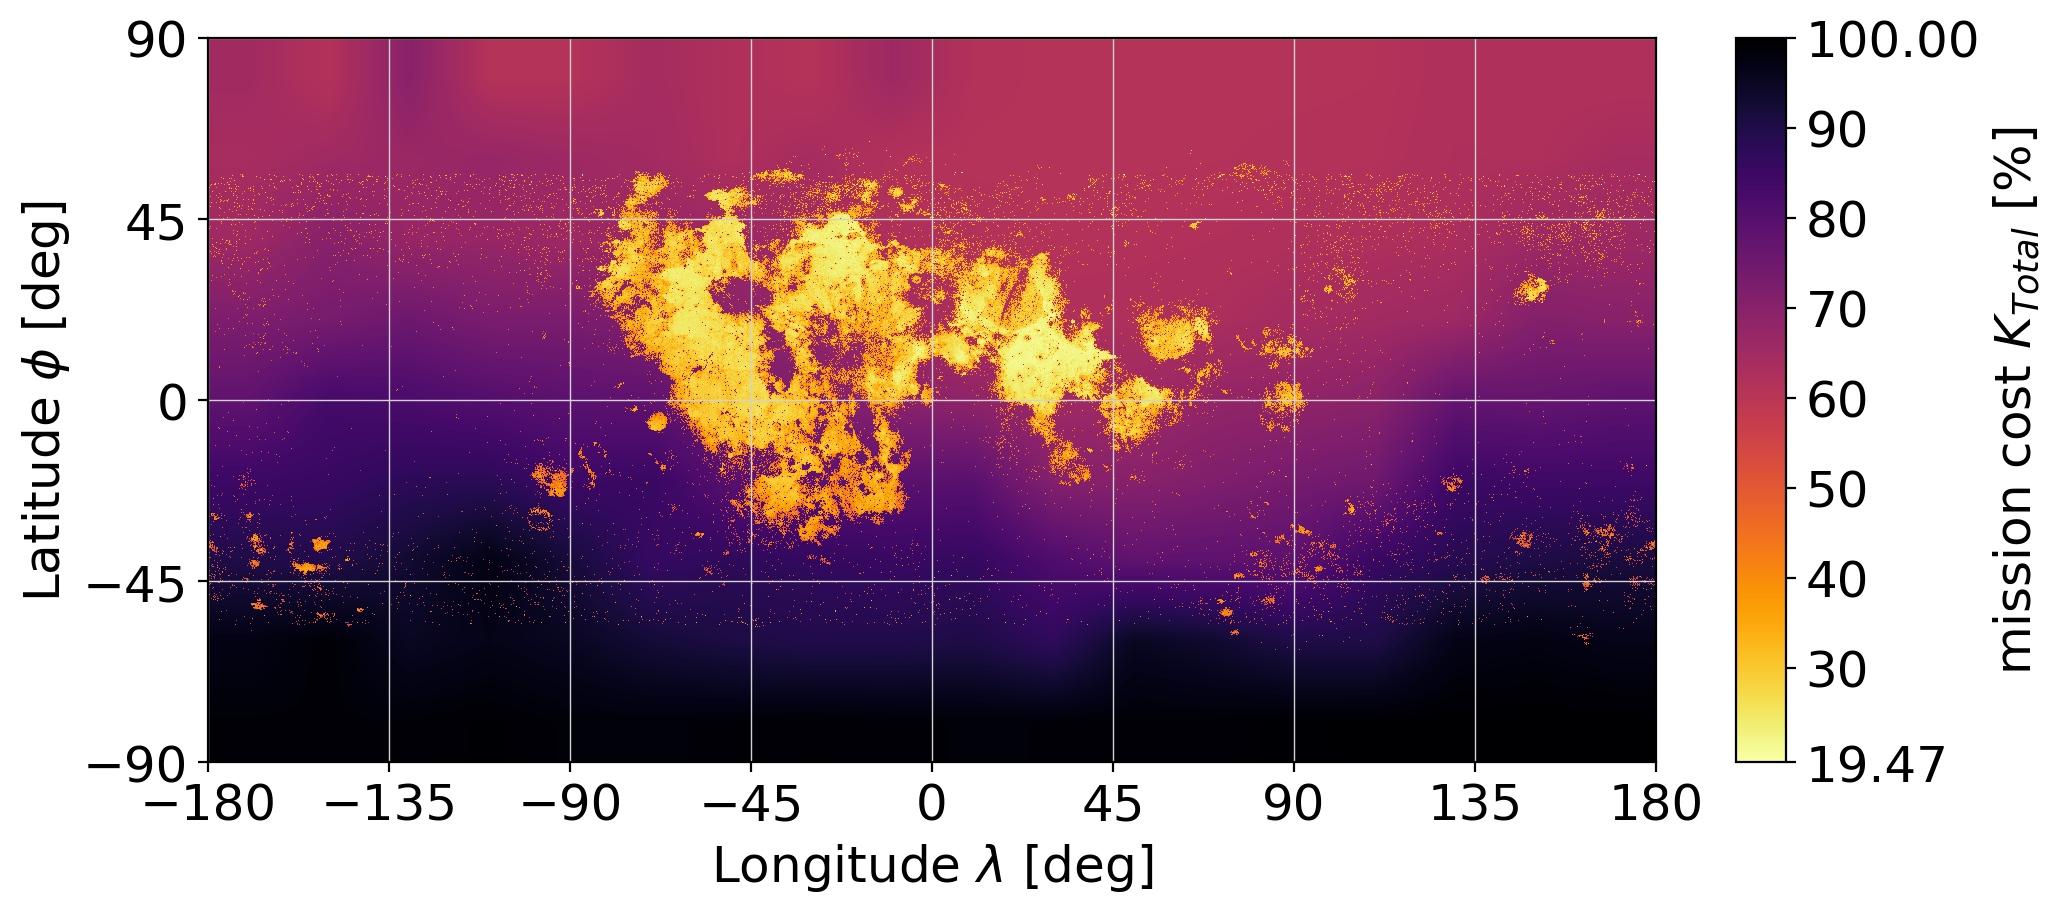

In [18]:
plot_map(Total_cost_map_advanced_2_5,np.max(Total_cost_map_advanced_2_5)/100,'mission cost $K_{Total}$ [%]',(-90,90),(-180,180),cmap=revinferno,i_steps=np.array([30,40,50,60,70,80,90])*(np.max(Total_cost_map_advanced_2_5)/100),silent=True,labelsize=18,save="Total_Cost_NRHO_2_0.pdf",gridcolor='lightgray')

In [20]:
r_m_1 = '8.555'
r_m_2 = '10.688'

In [21]:
# Compute Fix costs and dynamic costs

x = np.linspace(0,200,100)

fix_costs_1_5 = []
fix_cost_1_5_min = np.zeros(x.shape) # ISRU cost + additional ISRU cost
fix_cost_1_5_max = np.zeros(x.shape)

dyn_costs_1_5 = []
dyn_cost_1_5_min = np.zeros(x.shape) # dynamic costs H2
dyn_cost_1_5_max = np.zeros(x.shape)

print(f'Computing fix and dynamic costs for mass ratio = {r_m_1}')
with tqdm(total=len(x)) as pbar: 
    for i, year in enumerate(x):
        fix_cost_1_5 , dyn_cost_1_5 = total_costs_advanced_1_5(year, return_splits=True)
        fix_costs_1_5.append(fix_cost_1_5)
        dyn_costs_1_5.append(dyn_cost_1_5)
        fix_cost_1_5_min[i] = np.min(fix_cost_1_5)
        fix_cost_1_5_max[i] = np.max(fix_cost_1_5)
        dyn_cost_1_5_min[i] = np.min(dyn_cost_1_5)
        dyn_cost_1_5_max[i] = np.max(dyn_cost_1_5)
        pbar.update(1)


fix_costs_2_5 = []
fix_cost_2_5_min = np.zeros(x.shape) # ISRU cost + additional ISRU cost
fix_cost_2_5_max = np.zeros(x.shape)

dyn_costs_2_5 = []
dyn_cost_2_5_min = np.zeros(x.shape) # dynamic costs H2
dyn_cost_2_5_max = np.zeros(x.shape)

print(f'Computing fix and dynamic costs for mass ratio = {r_m_2}')
with tqdm(total=len(x)) as pbar: 
    for i, year in enumerate(x):
        fix_cost_2_5 , dyn_cost_2_5 = total_costs_advanced_2_5(year, return_splits=True)
        fix_costs_2_5.append(fix_cost_2_5)
        dyn_costs_2_5.append(dyn_cost_2_5)
        fix_cost_2_5_min[i] = np.min(fix_cost_2_5)
        fix_cost_2_5_max[i] = np.max(fix_cost_2_5)
        dyn_cost_2_5_min[i] = np.min(dyn_cost_2_5)
        dyn_cost_2_5_max[i] = np.max(dyn_cost_2_5)
        pbar.update(1)

Computing fix and dynamic costs for mass ratio = 8.555


  0%|          | 0/100 [00:00<?, ?it/s]

Computing fix and dynamic costs for mass ratio = 10.688


  0%|          | 0/100 [00:00<?, ?it/s]

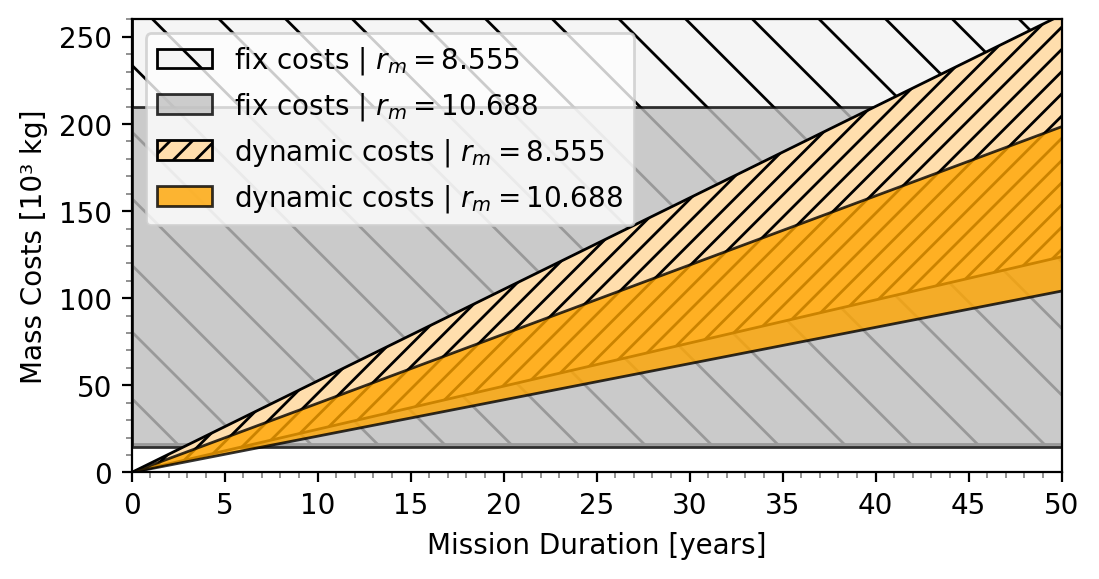

In [22]:
plt.figure(figsize=(6,3), dpi=200)
#plt.title("Cost components")
divider = 1000

# 1_5
#plt.plot(x,fix_cost_1_5_min/divider,color='tab:blue',linewidth=0.5)
#plt.plot(x,fix_cost_1_5_max/divider,color='tab:blue',linewidth=0.5)
plt.fill_between(x,fix_cost_1_5_min[0]/divider, fix_cost_1_5_max[0]/divider, color='whitesmoke', hatch='\\', edgecolor='black',alpha=1, label=f'fix costs | $r_m={r_m_1}$')

# 2_0
#plt.plot(x,fix_cost_2_5_min/divider,color='tab:blue',linewidth=0.5)
#plt.plot(x,fix_cost_2_5_max/divider,color='tab:blue',linewidth=0.5)
plt.fill_between(x,fix_cost_2_5_min[0]/divider, fix_cost_2_5_max[0]/divider, color='silver', hatch='', edgecolor='black',alpha=0.8, label=f'fix costs | $r_m={r_m_2}$')

# 1_5
#plt.plot(x,dyn_cost_1_5_min/divider,color='tab:orange',linewidth=0.5)
#plt.plot(x,dyn_cost_1_5_max/divider,color='tab:orange',linewidth=0.5)
plt.fill_between(x,dyn_cost_1_5_min/divider, dyn_cost_1_5_max/divider,color='navajowhite', hatch='///', edgecolor='black',alpha=1,  label=f'dynamic costs | $r_m={r_m_1}$')

# 2_0
#plt.plot(x,dyn_cost_2_5_min/divider,color='tab:orange',linewidth=0.5)
#plt.plot(x,dyn_cost_2_5_max/divider,color='tab:orange',linewidth=0.5)
plt.fill_between(x,dyn_cost_2_5_min/divider, dyn_cost_2_5_max/divider, color='orange', hatch='', edgecolor='black',alpha=0.8, label=f'dynamic costs | $r_m={r_m_2}$')

plt.ylim(0,260)
plt.xlim(0,50)
plt.legend(loc='upper left')
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(10))

ax.tick_params(axis='x', which='minor', colors='0.5')
ax.tick_params(axis='y', which='minor', colors='0.5')

plt.ylabel("Mass Costs [10³ kg]")
plt.xlabel("Mission Duration [years]")
plt.savefig('doc/img/cost_components.pdf', dpi=300,facecolor ='white', bbox_inches='tight',pad_inches = 0)
plt.show()

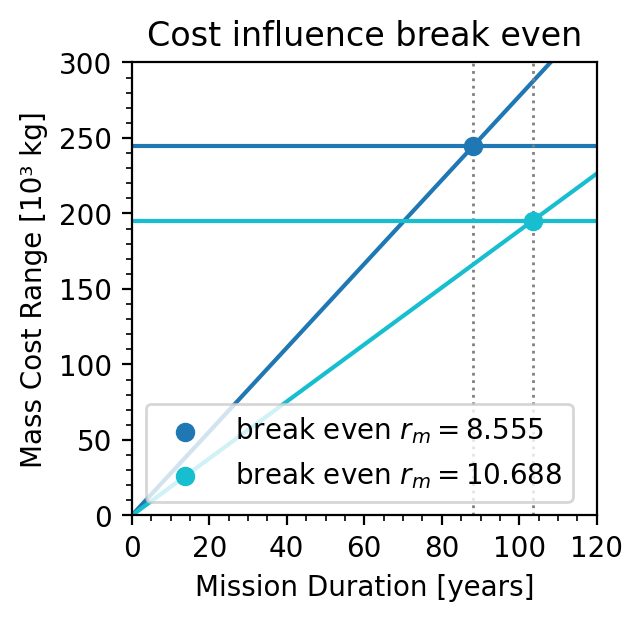

In [23]:
divider = 1000

plt.figure(figsize=(3,3), dpi=200)
plt.title("Cost influence break even")

plt.plot(x,(fix_cost_1_5_max - fix_cost_1_5_min)/divider,color='tab:blue') # ISRU range
plt.plot(x,(dyn_cost_1_5_max - dyn_cost_1_5_min)/divider,color='tab:blue') # Transport range
breakeven_1_5 = 88.1
plt.scatter(breakeven_1_5,((fix_cost_1_5_max - fix_cost_1_5_min)/divider)[0],color='tab:blue',zorder=5,label=f'break even $r_m={r_m_1}$')
plt.axvline(x=breakeven_1_5 ,linewidth=1, color='0.5',linestyle=":")

#print((fix_cost_1_5_max - fix_cost_1_5_min))
#breakeven_1_5 = (fix_cost_1_5_max - fix_cost_1_5_min) (dyn_cost_1_5_max - dyn_cost_1_5_min)

plt.plot(x,(fix_cost_2_5_max - fix_cost_2_5_min)/divider,color='tab:cyan') # ISRU range
plt.plot(x,(dyn_cost_2_5_max - dyn_cost_2_5_min)/divider,color='tab:cyan') # Transport range
breakeven_2_5 = 103.5
plt.scatter(breakeven_2_5,((fix_cost_2_5_max - fix_cost_2_5_min)/divider)[0],color='tab:cyan',zorder=5,label=f'break even $r_m={r_m_2}$')
plt.axvline(x=breakeven_2_5 ,linewidth=1, color='0.5',linestyle=":")


#plt.xlim(0,1000)
#plt.xlim(0,20)
plt.ylim(0,300)
plt.xlim(0,120)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(10))
#ax.yaxis.set_major_locator(MultipleLocator(1))
plt.legend(loc='lower left')
plt.ylabel("Mass Cost Range [10³ kg]")
plt.xlabel("Mission Duration [years]")
plt.savefig('doc/img/breakeven.pdf', dpi=300,facecolor ='white', bbox_inches='tight',pad_inches = 0)
plt.show()
# after 2080 years it has a higher influence range

## Best location - Tiles
comparing ISRU only to Combined Model over time 

In [95]:
# ISRU only: -> ISRU_data_resized

# get map after t years

Total_1_5_0  = total_costs_advanced_1_5(0)
Total_1_5_10  = total_costs_advanced_1_5(10)
Total_1_5_20 = total_costs_advanced_1_5(20)

Total_2_5_0  = total_costs_advanced_2_5(0)
Total_2_5_10  = total_costs_advanced_2_5(10)
Total_2_5_20 = total_costs_advanced_2_5(20)

In [96]:
# ranking best tiles : low to high

def rank_tiles(tile_img):

    table = PrettyTable()
    table.field_names = ["Rank", "Tile", "value [kg]"]

    n_tops = 10

    values_ranked = np.unique(np.sort(tile_img, axis=None))

    for i in range(n_tops):
        
        nr_x_tiles = np.where(tile_img == values_ranked[i])

        for j in range(len(nr_x_tiles[0])):
            table.add_row([i+1,f'$T_{"{"}{nr_x_tiles[0][j]},{nr_x_tiles[1][j]}{"}"}$',f'{values_ranked[i]:0.2f}'])
            #print(f'Rank #{i+1} tile $T_{"{"}{nr_x_tiles[0][j]},{nr_x_tiles[1][j]}{"}"}$  value  {values_ranked[i]}')
    
    print(table)

    

In [97]:
# -------------------------------------------
# for 1 deg Tiles - first mass ratio 
# ------------------------------------------

In [98]:
# downsample into square tiles

tile_size = 1 # [deg]

Lat_res = int(180 / tile_size)
Lon_res = int(360 / tile_size)
dsize_tiles = (Lon_res,Lat_res)

def tile_down(img):
    # settled on INTER_AREA interpolation after comparison
    new_img = cv2.resize(img, dsize=dsize_tiles, interpolation=cv2.INTER_AREA)
    return new_img


ISRU_tiled = tile_down(ISRU_data_resized)

Tile_Total_1_5_0  = tile_down(Total_1_5_0)
Tile_Total_1_5_10 = tile_down(Total_1_5_10)
Tile_Total_1_5_20 = tile_down(Total_1_5_20)

# not used - no gain of information
Tile_Total_2_5_0  = tile_down(Total_2_5_0)
Tile_Total_2_5_10 = tile_down(Total_2_5_10)
Tile_Total_2_5_20 = tile_down(Total_2_5_20)

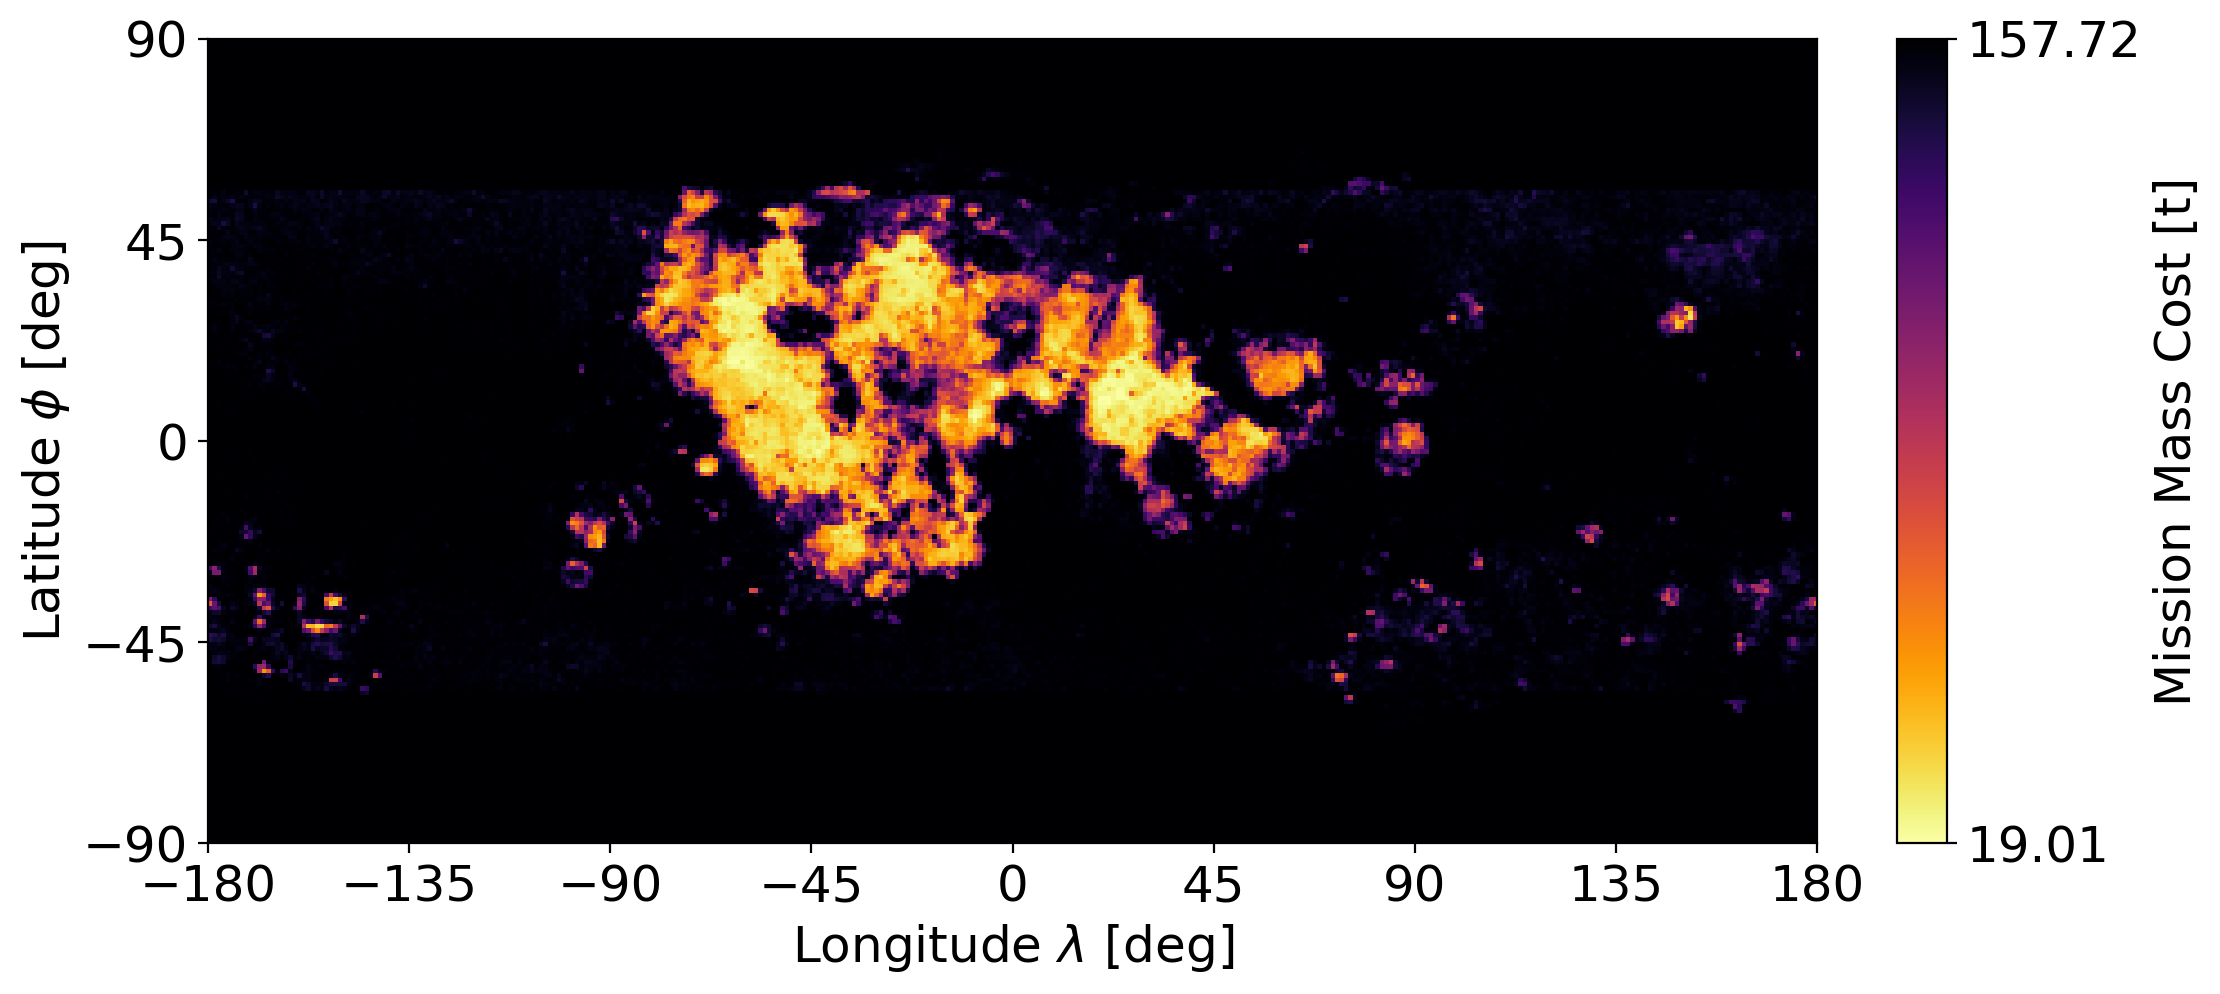

In [99]:
plot_map(ISRU_tiled,1000,'Mission Mass Cost [t]',(-90,90),(-180,180),cmap=revinferno,i_steps=np.array([]),silent=True,labelsize=18)

In [100]:
rank_tiles(ISRU_tiled)

+------+--------------+------------+
| Rank |     Tile     | value [kg] |
+------+--------------+------------+
|  1   | $T_{79,204}$ |  19007.80  |
|  2   | $T_{81,201}$ |  19224.94  |
|  3   | $T_{80,200}$ |  19310.66  |
|  4   | $T_{72,118}$ |  19391.52  |
|  5   | $T_{80,201}$ |  19405.84  |
|  6   | $T_{84,171}$ |  19440.94  |
|  7   | $T_{72,117}$ |  19642.82  |
|  8   | $T_{81,199}$ |  19653.04  |
|  9   | $T_{72,116}$ |  19765.88  |
|  10  | $T_{80,204}$ |  19777.27  |
+------+--------------+------------+


In [101]:
rank_tiles(Tile_Total_1_5_0)

+------+--------------+------------+
| Rank |     Tile     | value [kg] |
+------+--------------+------------+
|  1   | $T_{79,204}$ |  19145.01  |
|  2   | $T_{81,201}$ |  19567.47  |
|  3   | $T_{80,200}$ |  19617.05  |
|  4   | $T_{80,201}$ |  19687.05  |
|  5   | $T_{80,204}$ |  19980.74  |
|  6   | $T_{81,199}$ |  20062.62  |
|  7   | $T_{80,203}$ |  20087.61  |
|  8   | $T_{79,203}$ |  20183.69  |
|  9   | $T_{80,199}$ |  20221.10  |
|  10  | $T_{81,200}$ |  20484.52  |
+------+--------------+------------+


In [102]:
rank_tiles(Tile_Total_1_5_10)

+------+--------------+------------+
| Rank |     Tile     | value [kg] |
+------+--------------+------------+
|  1   | $T_{79,204}$ |  45933.94  |
|  2   | $T_{80,200}$ |  46750.01  |
|  3   | $T_{80,201}$ |  46763.91  |
|  4   | $T_{81,201}$ |  46776.97  |
|  5   | $T_{80,204}$ |  46889.33  |
|  6   | $T_{79,203}$ |  47024.42  |
|  7   | $T_{80,203}$ |  47052.29  |
|  8   | $T_{76,201}$ |  47095.59  |
|  9   | $T_{78,218}$ |  47191.63  |
|  10  | $T_{78,204}$ |  47380.44  |
+------+--------------+------------+


In [103]:
rank_tiles(Tile_Total_1_5_20)

+------+--------------+------------+
| Rank |     Tile     | value [kg] |
+------+--------------+------------+
|  1   | $T_{79,204}$ |  72722.88  |
|  2   | $T_{71,206}$ |  73397.47  |
|  3   | $T_{78,218}$ |  73589.69  |
|  4   | $T_{76,201}$ |  73642.25  |
|  5   | $T_{75,206}$ |  73717.15  |
|  6   | $T_{77,212}$ |  73747.70  |
|  7   | $T_{76,206}$ |  73769.27  |
|  8   | $T_{80,204}$ |  73797.92  |
|  9   | $T_{80,201}$ |  73840.78  |
|  10  | $T_{79,203}$ |  73865.14  |
+------+--------------+------------+


In [104]:
# display tile evolution in table manually

In [105]:
# -------------------------------------------
# for 5 deg Tiles - first mass ratio 
# ------------------------------------------

In [106]:
# downsample into square tiles

tile_size = 5 # [deg]

Lat_res = int(180 / tile_size)
Lon_res = int(360 / tile_size)
dsize_tiles = (Lon_res,Lat_res)

def tile_down(img):
    # settled on INTER_AREA interpolation after comparison
    new_img = cv2.resize(img, dsize=dsize_tiles, interpolation=cv2.INTER_AREA)
    return new_img


ISRU_tiled = tile_down(ISRU_data_resized)

Tile_Total_1_5_0  = tile_down(Total_1_5_0)
Tile_Total_1_5_10 = tile_down(Total_1_5_10)
Tile_Total_1_5_20 = tile_down(Total_1_5_20)

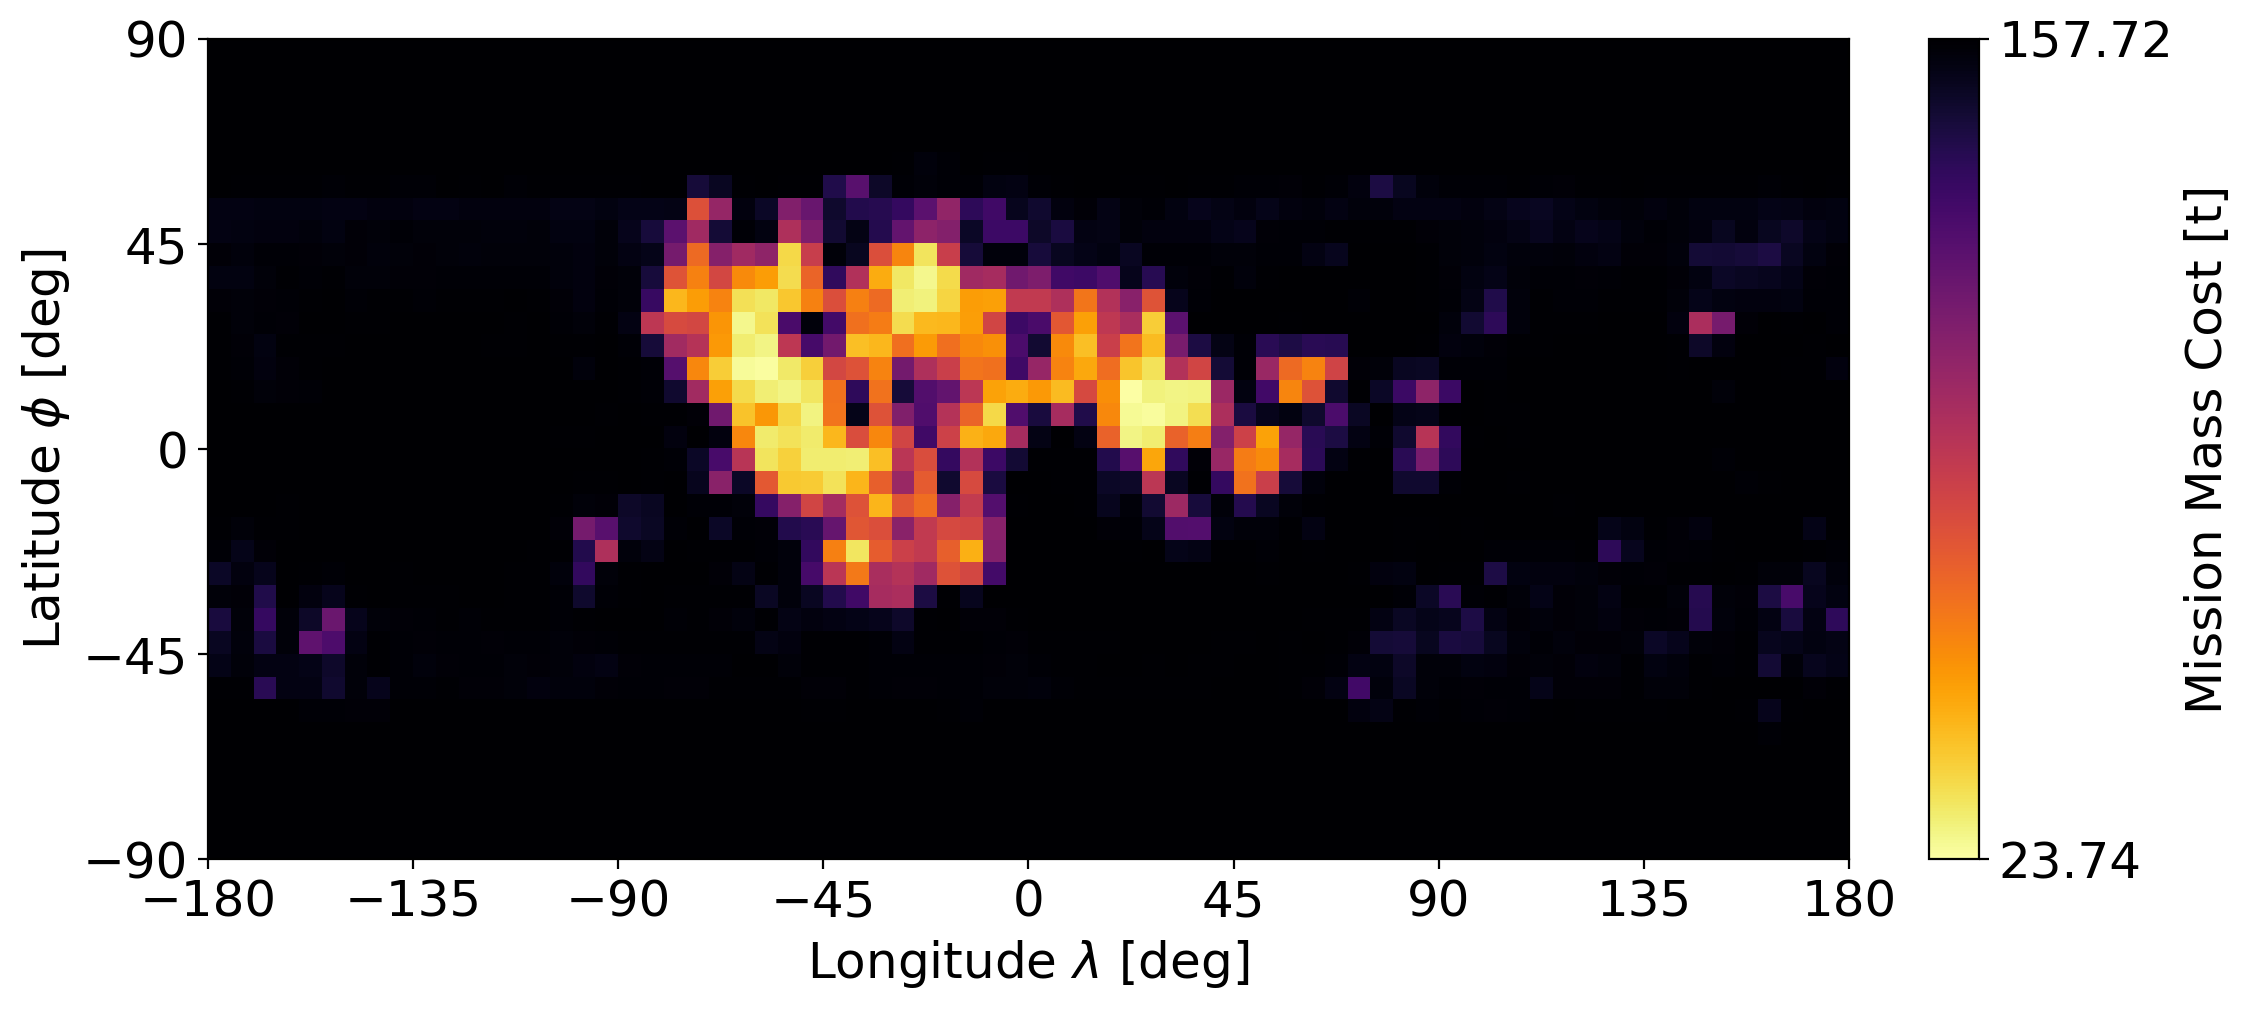

In [107]:
plot_map(ISRU_tiled,1000,'Mission Mass Cost [t]',(-90,90),(-180,180),cmap=revinferno,i_steps=np.array([]),silent=True,labelsize=18)

In [108]:
rank_tiles(ISRU_tiled)

+------+-------------+------------+
| Rank |     Tile    | value [kg] |
+------+-------------+------------+
|  1   | $T_{15,40}$ |  23741.12  |
|  2   | $T_{14,24}$ |  24505.57  |
|  3   | $T_{16,41}$ |  25204.07  |
|  4   | $T_{14,23}$ |  25320.66  |
|  5   | $T_{16,40}$ |  26239.13  |
|  6   | $T_{12,23}$ |  27051.90  |
|  7   | $T_{10,31}$ |  27385.66  |
|  8   | $T_{13,24}$ |  28137.99  |
|  9   | $T_{15,25}$ |  28143.81  |
|  10  | $T_{15,42}$ |  28152.99  |
+------+-------------+------------+


In [109]:
rank_tiles(Tile_Total_1_5_0)

+------+-------------+------------+
| Rank |     Tile    | value [kg] |
+------+-------------+------------+
|  1   | $T_{15,40}$ |  23812.16  |
|  2   | $T_{16,41}$ |  25495.80  |
|  3   | $T_{16,40}$ |  26768.87  |
|  4   | $T_{14,24}$ |  27286.77  |
|  5   | $T_{10,31}$ |  27636.68  |
|  6   | $T_{15,42}$ |  28002.98  |
|  7   | $T_{15,43}$ |  28485.64  |
|  8   | $T_{14,23}$ |  28491.53  |
|  9   | $T_{15,41}$ |  29137.08  |
|  10  | $T_{16,42}$ |  29164.60  |
+------+-------------+------------+


In [110]:
rank_tiles(Tile_Total_1_5_10)

+------+-------------+------------+
| Rank |     Tile    | value [kg] |
+------+-------------+------------+
|  1   | $T_{15,40}$ |  50448.17  |
|  2   | $T_{16,41}$ |  52449.66  |
|  3   | $T_{16,40}$ |  54046.21  |
|  4   | $T_{15,42}$ |  54312.41  |
|  5   | $T_{10,31}$ |  54521.57  |
|  6   | $T_{15,43}$ |  54789.89  |
|  7   | $T_{15,41}$ |  55557.09  |
|  8   | $T_{16,42}$ |  55952.42  |
|  9   | $T_{17,40}$ |  57122.74  |
|  10  | $T_{11,31}$ |  57366.35  |
+------+-------------+------------+


In [111]:
rank_tiles(Tile_Total_1_5_20)

+------+-------------+------------+
| Rank |     Tile    | value [kg] |
+------+-------------+------------+
|  1   | $T_{15,40}$ |  77084.18  |
|  2   | $T_{16,41}$ |  79403.53  |
|  3   | $T_{15,42}$ |  80621.85  |
|  4   | $T_{15,43}$ |  81094.15  |
|  5   | $T_{16,40}$ |  81323.56  |
|  6   | $T_{10,31}$ |  81406.45  |
|  7   | $T_{15,41}$ |  81977.11  |
|  8   | $T_{16,42}$ |  82740.25  |
|  9   | $T_{11,31}$ |  84729.91  |
|  10  | $T_{14,41}$ |  84940.36  |
+------+-------------+------------+


In [112]:
# -------------------------------------------
# for 15 deg Tiles - first mass ratio 
# ------------------------------------------

In [113]:
# downsample into square tiles

tile_size = 15 # [deg]

Lat_res = int(180 / tile_size)
Lon_res = int(360 / tile_size)
dsize_tiles = (Lon_res,Lat_res)

def tile_down(img):
    # settled on INTER_AREA interpolation after comparison
    new_img = cv2.resize(img, dsize=dsize_tiles, interpolation=cv2.INTER_AREA)
    return new_img


ISRU_tiled = tile_down(ISRU_data_resized)

Tile_Total_1_5_0  = tile_down(Total_1_5_0)
Tile_Total_1_5_10 = tile_down(Total_1_5_10)
Tile_Total_1_5_20 = tile_down(Total_1_5_20)

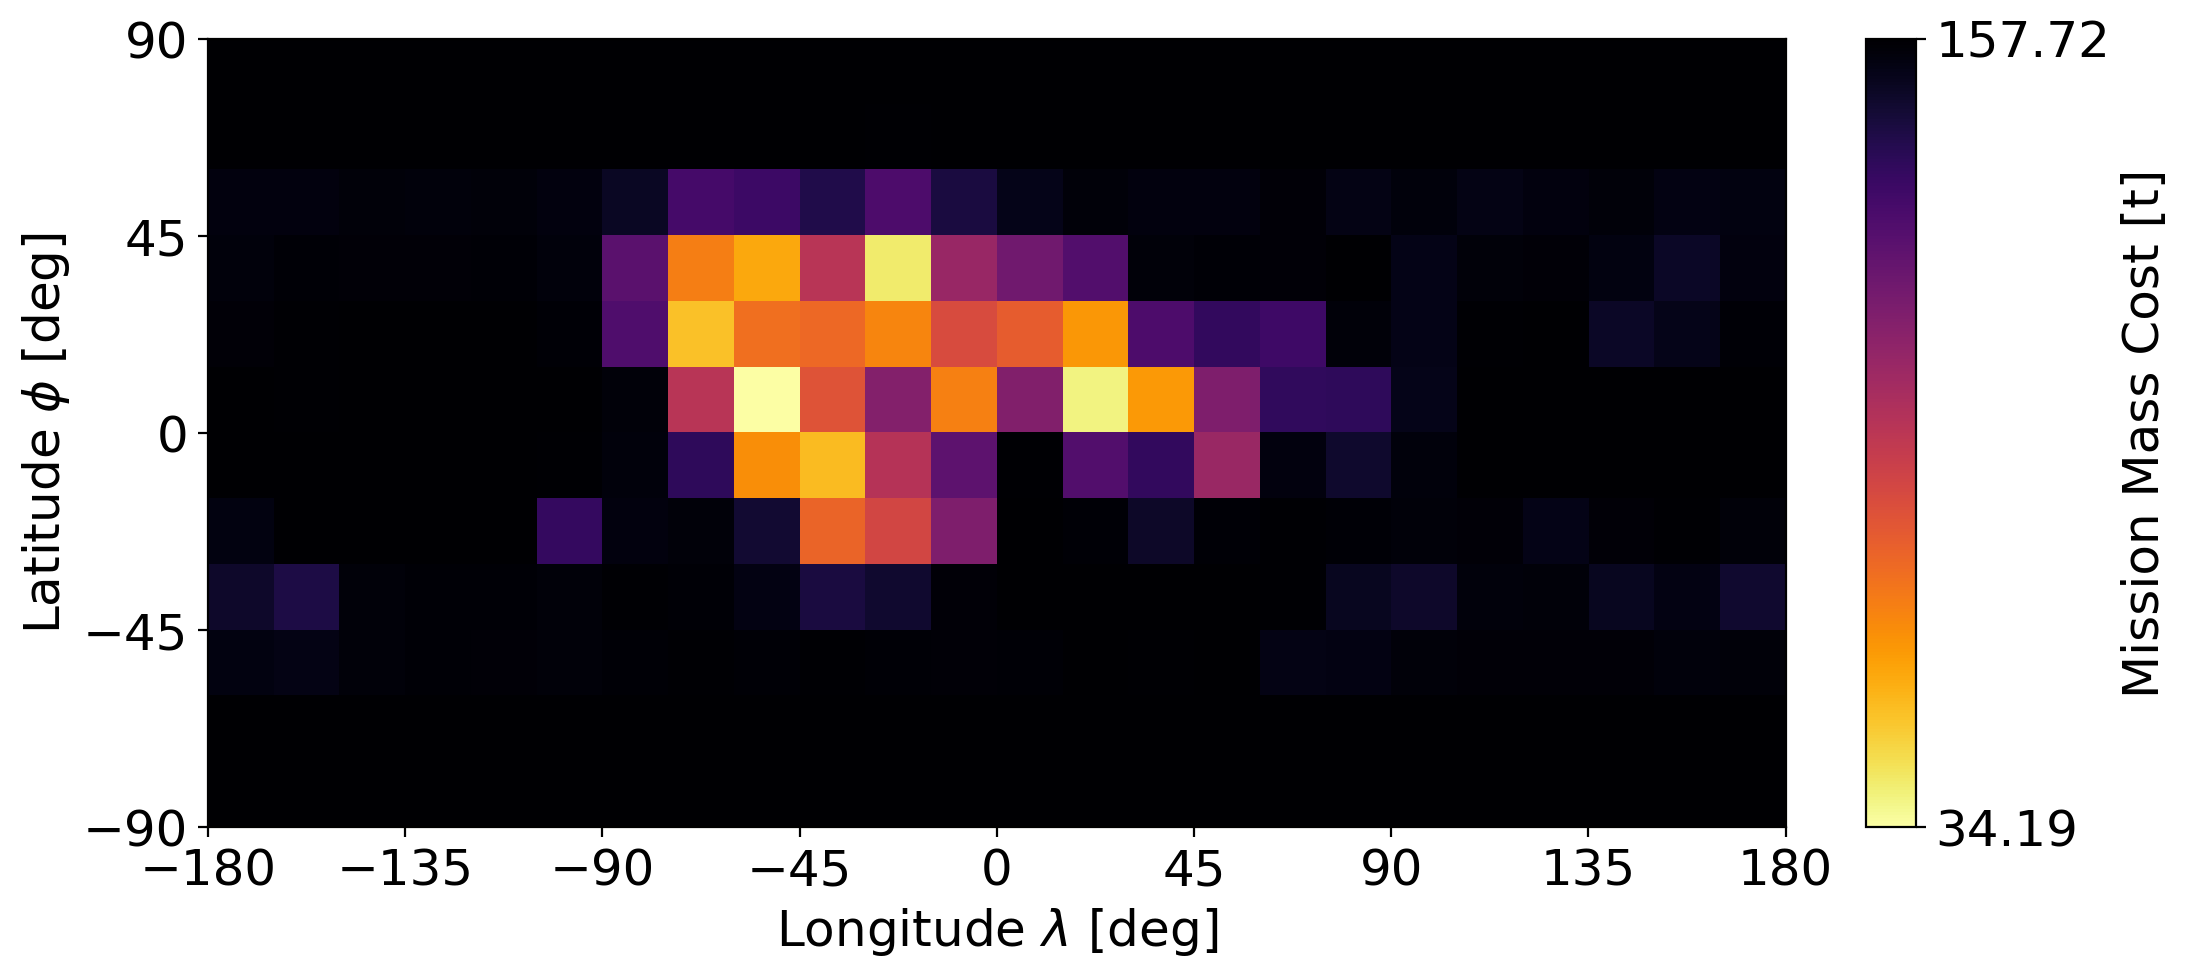

In [114]:
plot_map(ISRU_tiled,1000,'Mission Mass Cost [t]',(-90,90),(-180,180),cmap=revinferno,i_steps=np.array([]),silent=True,labelsize=18)

In [115]:
rank_tiles(ISRU_tiled)

+------+------------+------------+
| Rank |    Tile    | value [kg] |
+------+------------+------------+
|  1   | $T_{5,8}$  |  34191.32  |
|  2   | $T_{5,13}$ |  38869.82  |
|  3   | $T_{3,10}$ |  41357.81  |
|  4   | $T_{4,7}$  |  51617.97  |
|  5   | $T_{6,9}$  |  53096.10  |
|  6   | $T_{3,8}$  |  57895.27  |
|  7   | $T_{5,14}$ |  62119.26  |
|  8   | $T_{4,13}$ |  62535.44  |
|  9   | $T_{6,8}$  |  64838.15  |
|  10  | $T_{4,10}$ |  67463.76  |
+------+------------+------------+


In [116]:
rank_tiles(Tile_Total_1_5_0)

+------+------------+------------+
| Rank |    Tile    | value [kg] |
+------+------------+------------+
|  1   | $T_{5,8}$  |  39336.18  |
|  2   | $T_{5,13}$ |  39792.43  |
|  3   | $T_{3,10}$ |  41667.46  |
|  4   | $T_{4,7}$  |  57468.98  |
|  5   | $T_{3,8}$  |  60468.32  |
|  6   | $T_{4,13}$ |  61162.58  |
|  7   | $T_{5,14}$ |  62652.84  |
|  8   | $T_{6,9}$  |  63325.94  |
|  9   | $T_{4,10}$ |  70891.61  |
|  10  | $T_{5,11}$ |  72830.55  |
+------+------------+------------+


In [117]:
rank_tiles(Tile_Total_1_5_10)

+------+------------+------------+
| Rank |    Tile    | value [kg] |
+------+------------+------------+
|  1   | $T_{5,13}$ |  67069.76  |
|  2   | $T_{3,10}$ |  68603.68  |
|  3   | $T_{5,8}$  |  71767.38  |
|  4   | $T_{4,13}$ |  86820.56  |
|  5   | $T_{4,7}$  |  88459.16  |
|  6   | $T_{3,8}$  |  88864.45  |
|  7   | $T_{5,14}$ |  89432.02  |
|  8   | $T_{6,9}$  |  97206.53  |
|  9   | $T_{4,10}$ |  99234.46  |
|  10  | $T_{5,11}$ | 101814.12  |
+------+------------+------------+


In [118]:
rank_tiles(Tile_Total_1_5_20)

+------+------------+------------+
| Rank |    Tile    | value [kg] |
+------+------------+------------+
|  1   | $T_{5,13}$ |  94347.10  |
|  2   | $T_{3,10}$ |  95539.89  |
|  3   | $T_{5,8}$  | 104198.57  |
|  4   | $T_{4,13}$ | 112478.55  |
|  5   | $T_{5,14}$ | 116211.21  |
|  6   | $T_{3,8}$  | 117260.58  |
|  7   | $T_{4,7}$  | 119449.33  |
|  8   | $T_{4,10}$ | 127577.30  |
|  9   | $T_{4,12}$ | 130753.64  |
|  10  | $T_{5,11}$ | 130797.70  |
+------+------------+------------+


In [119]:
# colors in LaTex Table

#00ff00
#88ff00
#b8ff00
#e8ff00
#ffff00
#ffee00
#ffdd00
#ffcc00
#ffbb00
#ffaa00
